In [ ]:
import os
import re
import sys
sys.path.append('../')
import json
import pywt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import perf_counter
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from sklearn.linear_model import RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from transform import TimeSeriesTransform

In [2]:
cfg = json.load(open("../config/config.json"))

ts_trans = TimeSeriesTransform(cfg)

In [3]:
INSTANCES_DIR = '../data/linear_acuator/instances/'
INFERENCE_DIR = '../data/linear_acuator/inference/'
STATES = ['normal', 
            'backlash1', 'backlash2',
            'lackLubrication1', 'lackLubrication2',
            'spalling1', 'spalling2', 'spalling3', 'spalling4', 'spalling5', 'spalling6', 'spalling7', 'spalling8']
LOADS= ['20kg', '40kg', '-40kg']

In [4]:
load = '20kg'
filenames_20kg = [os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES]
filenames_20kg = [filename for sublist in filenames_20kg for filename in sublist]

load = '40kg'
filenames_40kg = [os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES]
filenames_40kg = [filename for sublist in filenames_40kg for filename in sublist]

load = '-40kg'
filenames_m40kg = [os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES]
filenames_m40kg = [filename for sublist in filenames_m40kg for filename in sublist]

In [5]:
def get_X_y(filenames, load, is_train=True):
    X, y = [], []
    data_dir = INSTANCES_DIR if is_train else INFERENCE_DIR
    for filename in filenames:
        load_num = load[:-2]
        state = re.match(fr'(.*)_{load_num}', filename).group(1)
        df = pd.read_csv(os.path.join(data_dir, load, state, filename))
        tmp_cur = ts_trans.smoothing(ts_df=df, field='current')
        # tmp_pos = ts_transform.smoothing(ts_df=df, field='position_error')
        X.append(tmp_cur)
        y.append(state)
    return np.array(X), np.array(y)

In [6]:
X_20kg, y_20kg = get_X_y(filenames_20kg, load='20kg')
X_40kg, y_40kg = get_X_y(filenames_40kg, load='40kg')
X_m40kg, y_m40kg = get_X_y(filenames_m40kg, load='-40kg')

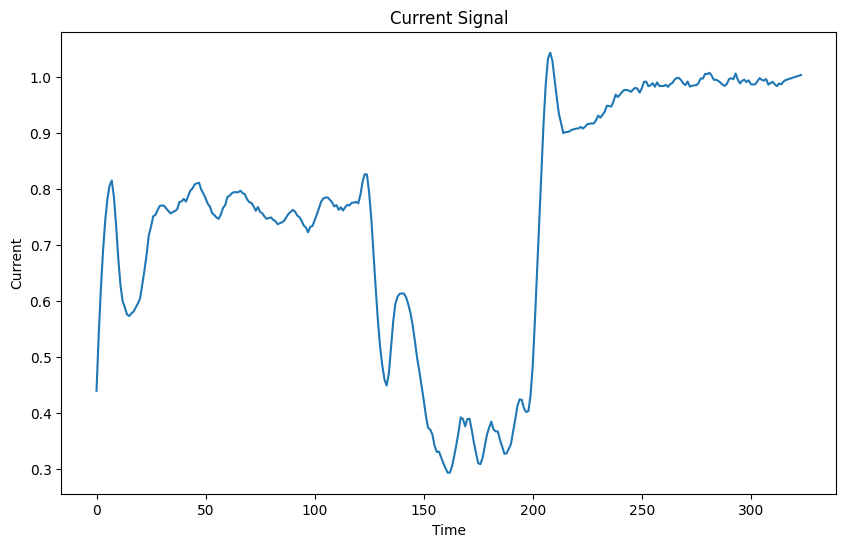

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(X_20kg[0])
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Current Signal')
plt.show()

In [8]:
minmax_X_20kg = 2 * (X_20kg - np.min(X_20kg, axis=1, keepdims=True)) / (np.max(X_20kg, axis=1, keepdims=True) - np.min(X_20kg, axis=1, keepdims=True)) - 1
minmax_X_40kg = 2 * (X_40kg - np.min(X_40kg, axis=1, keepdims=True)) / (np.max(X_40kg, axis=1, keepdims=True) - np.min(X_40kg, axis=1, keepdims=True)) - 1
minmax_X_m40kg = 2 * (X_m40kg - np.min(X_m40kg, axis=1, keepdims=True)) / (np.max(X_m40kg, axis=1, keepdims=True) - np.min(X_m40kg, axis=1, keepdims=True)) - 1

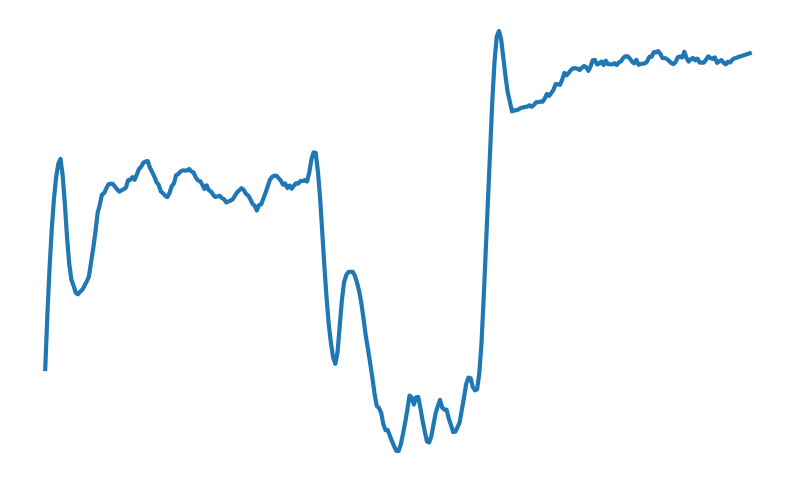

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(minmax_X_20kg[0], linewidth=3)
plt.xlabel('Time')
plt.ylabel('Normalized Current')
# plt.title('Minmax Normalized Current Signal')
plt.axis('off')  # Turn off the x and y axes
plt.show()

In [10]:
lower_bound = 0.1   # Lower bound of the range (inclusive)
upper_bound = 500  # Upper bound of the range (exclusive)
n_kernels = 300
np.random.seed(42)  # for reproducibility
random_scales = np.random.uniform(lower_bound, upper_bound, n_kernels)
wavelet = 'morl' 

In [11]:
coefficients, freqs = pywt.cwt(minmax_X_20kg[0], random_scales, wavelet, method='conv')
coefficients.shape

(300, 324)

In [12]:
x_arr = np.arange(0, len(coefficients[0]))
x_arr = np.tile(x_arr, (coefficients.shape[0], 1))
x_arr.shape

(300, 324)

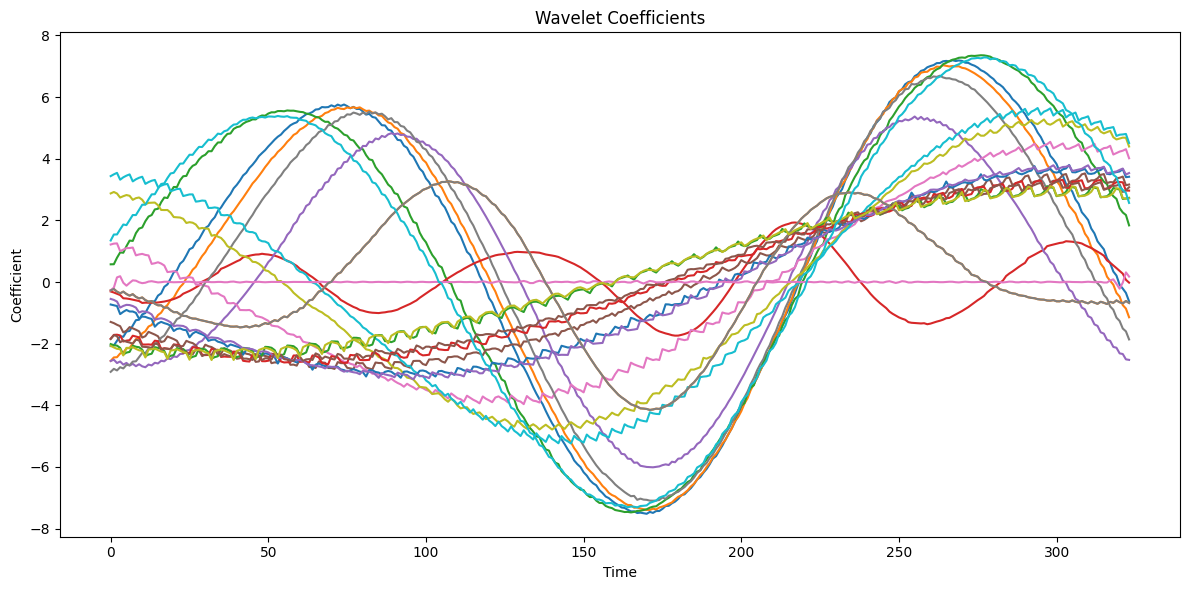

In [13]:
rand_idx = [np.random.randint(coefficients.shape[0]) for _ in range(20)]

plt.figure(figsize=(12, 6))
for i in range(20):
    plt.plot(x_arr[0], coefficients[rand_idx[i]])
    plt.xlabel('Time')
    plt.ylabel('Coefficient')
    plt.title('Wavelet Coefficients')

plt.tight_layout()
plt.show()

In [14]:
res = np.array([np.trapz(coeff) for coeff in coefficients])
print(f'After integral: {res.shape}')
res

After integral: (300,)


C:\Users\MOSS_8192\AppData\Local\Temp\ipykernel_5876\949713735.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  res = np.array([np.trapz(coeff) for coeff in coefficients])


array([ 3.66728120e+02,  1.15955844e+02, -6.46113230e+01, -6.36469817e+01,
        1.95288973e+01,  1.95394901e+01,  6.16364384e+00,  3.83175986e+01,
       -6.60087735e+01, -7.88648683e+01,  1.01437416e+00,  1.31931676e+02,
        9.31538685e+00,  1.28185447e+01,  2.61774618e+00,  1.80739036e+00,
        3.00143019e+02,  3.61869486e+01,  2.59047207e+02,  2.61037867e+02,
       -7.37250667e+01,  2.34649725e+01,  2.63674447e+02,  3.72819105e+02,
        1.96260613e+02, -3.11167727e+01,  1.08231851e+00,  5.74997156e+01,
       -5.86610402e+01,  6.23962484e+00, -6.84874137e+01,  9.58917227e+00,
        6.13862222e+00,  1.12596082e+02,  1.27217346e+02, -1.24429262e+01,
        3.02116243e+02,  8.22969018e+00, -8.36511194e+01,  2.38049754e+02,
        1.77587854e+01,  9.93508793e+01,  5.05622660e+00,  8.06531901e+01,
        1.41226500e+02, -8.52287526e+01,  3.21642134e+02,  4.48411415e+01,
       -2.53868618e+00,  1.20514341e+00,  1.34707124e+02, -3.91717481e+01,
        1.06074692e+02,  

In [20]:
def raven(sample, random_scales, wavelet):
    coefficients, _ = pywt.cwt(sample, random_scales, wavelet, method='conv')
    # x_arr = np.arange(0, len(coefficients[0]))
    # x_arr = np.tile(x_arr, (coefficients.shape[0], 1))
    integral = np.array([np.trapezoid(coeff) for coeff in coefficients])
    return integral

def raven_parallel(X, random_scales, wavelet, max_workers=8):
    raven_results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(raven, X[i], random_scales, wavelet) for i in range(len(X))]
        for future in tqdm(futures):
            raven_results.append(future.result())
    return raven_results

In [21]:
time_a = perf_counter()
raven_results_20kg_p = raven_parallel(minmax_X_20kg, random_scales, wavelet)
time_b = perf_counter()
print(f'Parallel execution time: {time_b - time_a} seconds')

raven_results_20kg_np = np.array(raven_results_20kg_p)
print(raven_results_20kg_np.shape)

ridge_20 = RidgeClassifierCV()
ridge_20.fit(raven_results_20kg_np, y_20kg)

lda_20 = LDA()
lda_20.fit(raven_results_20kg_np, y_20kg)

print(f'Ridge 20kg: {ridge_20.score(raven_results_20kg_np, y_20kg)}')
print(f'LDA 20kg: {lda_20.score(raven_results_20kg_np, y_20kg)}')

100%|██████████| 455/455 [00:10<00:00, 44.08it/s]

Parallel execution time: 10.33067310001934 seconds
(455, 300)
Ridge 20kg: 0.9362637362637363
LDA 20kg: 0.9978021978021978


In [22]:
raven_results_40kg_p = raven_parallel(minmax_X_40kg, random_scales, wavelet)
raven_results_40kg_np = np.array(raven_results_40kg_p)
print(raven_results_40kg_np.shape)

ridge_40 = RidgeClassifierCV()
ridge_40.fit(raven_results_40kg_np, y_40kg)

lda_40 = LDA()
lda_40.fit(raven_results_40kg_np, y_40kg)

print(f'Ridge 40kg: {ridge_40.score(raven_results_40kg_np, y_40kg)}')
print(f'LDA 40kg: {lda_40.score(raven_results_40kg_np, y_40kg)}')

100%|██████████| 452/452 [00:10<00:00, 43.76it/s]


(452, 300)
Ridge 40kg: 0.9690265486725663
LDA 40kg: 1.0


In [23]:
raven_results_m40kg_p = raven_parallel(minmax_X_m40kg, random_scales, wavelet)
raven_results_m40kg_np = np.array(raven_results_m40kg_p)
print(raven_results_m40kg_np.shape)

ridge_m40 = RidgeClassifierCV()
ridge_m40.fit(raven_results_m40kg_np, y_m40kg)

lda_m40 = LDA()
lda_m40.fit(raven_results_m40kg_np, y_m40kg)

print(f'Ridge -40kg: {ridge_m40.score(raven_results_m40kg_np, y_m40kg)}')
print(f'LDA -40kg: {lda_m40.score(raven_results_m40kg_np, y_m40kg)}')

100%|██████████| 455/455 [00:10<00:00, 44.63it/s]

(455, 300)
Ridge -40kg: 0.945054945054945
LDA -40kg: 0.9978021978021978


In [26]:
time = []
for _ in range(5):
    time_a = perf_counter()
    raven_results_20kg_p = raven_parallel(minmax_X_20kg, random_scales, wavelet)
    # ridge_20.fit(raven_results_20kg_np, y_20kg)
    lda_40.fit(raven_results_40kg_np, y_40kg)
    time_b = perf_counter()
    time.append(time_b - time_a)
print(f'average training time: {np.mean(time)} seconds')

  0%|          | 0/455 [00:00<?, ?it/s]

100%|██████████| 455/455 [00:10<00:00, 44.92it/s]

average training time: 10.116194599994923 seconds


In [27]:
# import pickle

# with open('../outputs/20kg_raven.pickle', 'wb') as f:
#     pickle.dump(raven_results_20kg_np, f)
# with open('../outputs/40kg_raven.pickle', 'wb') as f:
#     pickle.dump(raven_results_40kg_np, f)
# with open('../outputs/m40kg_raven.pickle', 'wb') as f:
#     pickle.dump(raven_results_m40kg_np, f)

In [28]:
# with open('../outputs/20kg_labels.pickle', 'wb') as f:
#     pickle.dump(y_20kg, f)
# with open('../outputs/40kg_labels.pickle', 'wb') as f:
#     pickle.dump(y_40kg, f)
# with open('../outputs/m40kg_labels.pickle', 'wb') as f:
#     pickle.dump(y_m40kg, f)

In [29]:
load = '20kg'
filenames_20kg_t = [os.listdir(os.path.join(INFERENCE_DIR, load, state)) for state in STATES]
filenames_20kg_t = [filename for sublist in filenames_20kg_t for filename in sublist]

load = '40kg'
filenames_40kg_t = [os.listdir(os.path.join(INFERENCE_DIR, load, state)) for state in STATES]
filenames_40kg_t = [filename for sublist in filenames_40kg_t for filename in sublist]

load = '-40kg'
filenames_m40kg_t = [os.listdir(os.path.join(INFERENCE_DIR, load, state)) for state in STATES]
filenames_m40kg_t = [filename for sublist in filenames_m40kg_t for filename in sublist]

In [30]:
X_20kg_t, y_20kg_t = get_X_y(filenames_20kg_t, load='20kg', is_train=False)
X_40kg_t, y_40kg_t = get_X_y(filenames_40kg_t, load='40kg', is_train=False)
X_m40kg_t, y_m40kg_t = get_X_y(filenames_m40kg_t, load='-40kg', is_train=False)

In [31]:
minmax_X_20kg_t = 2 * (X_20kg_t - np.min(X_20kg_t, axis=1, keepdims=True)) / (np.max(X_20kg_t, axis=1, keepdims=True) - np.min(X_20kg_t, axis=1, keepdims=True)) - 1
minmax_X_40kg_t = 2 * (X_40kg_t - np.min(X_40kg_t, axis=1, keepdims=True)) / (np.max(X_40kg_t, axis=1, keepdims=True) - np.min(X_40kg_t, axis=1, keepdims=True)) - 1
minmax_X_m40kg_t = 2 * (X_m40kg_t - np.min(X_m40kg_t, axis=1, keepdims=True)) / (np.max(X_m40kg_t, axis=1, keepdims=True) - np.min(X_m40kg_t, axis=1, keepdims=True)) - 1

In [32]:
raven_results_20kg_t = raven_parallel(minmax_X_20kg_t, random_scales, wavelet)
raven_results_20kg_t_np = np.array(raven_results_20kg_t)
print(f'Ridge 20kg test: {ridge_20.score(raven_results_20kg_t_np, y_20kg_t)}')
print(f'LDA 20kg test: {lda_20.score(raven_results_20kg_t_np, y_20kg_t)}')

100%|██████████| 195/195 [00:04<00:00, 45.98it/s]

Ridge 20kg test: 0.7230769230769231
LDA 20kg test: 0.8512820512820513


In [33]:
raven_results_40kg_t = raven_parallel(minmax_X_40kg_t, random_scales, wavelet)
raven_results_40kg_t_np = np.array(raven_results_40kg_t)
print(f'Ridge 40kg test:{ridge_40.score(raven_results_40kg_t_np, y_40kg_t)}')
print(f'LDA 40kg test: {lda_40.score(raven_results_40kg_t_np, y_40kg_t)}')

100%|██████████| 193/193 [00:04<00:00, 44.40it/s]

Ridge 40kg test:0.7098445595854922
LDA 40kg test: 0.8341968911917098


In [34]:
raven_result_m40kg_t = raven_parallel(minmax_X_m40kg_t, random_scales, wavelet)
raven_result_m40kg_t_np = np.array(raven_result_m40kg_t)
print(f'Ridge -40kg test: {ridge_m40.score(raven_result_m40kg_t_np, y_m40kg_t)}')
print(f'LDA -40kg test: {lda_m40.score(raven_result_m40kg_t_np, y_m40kg_t)}')

100%|██████████| 195/195 [00:04<00:00, 44.22it/s]

Ridge -40kg test: 0.6974358974358974
LDA -40kg test: 0.8051282051282052


## Use ROCKET for Comparison

In [29]:
from pyts.transformation import ROCKET

rocket = ROCKET(random_state=0)

rocket.fit(X_20kg)

rocket_results_20kg = rocket.transform(X_20kg)
rocket_results_20kg_t = rocket.transform(X_20kg_t)
rocket_20 = RidgeClassifierCV()
lda_20_ = LDA()
rocket_20.fit(rocket_results_20kg, y_20kg)
lda_20_.fit(rocket_results_20kg, y_20kg)
print(f'20kg train Ridge: {rocket_20.score(rocket_results_20kg, y_20kg)}')
print(f'20kg test Ridge: {rocket_20.score(rocket_results_20kg_t, y_20kg_t)}')
print(f'20kg train LDA: {lda_20_.score(rocket_results_20kg, y_20kg)}')
print(f'20kg test LDA: {lda_20_.score(rocket_results_20kg_t, y_20kg_t)}')

20kg train Ridge: 0.9978021978021978
20kg test Ridge: 0.7076923076923077
20kg train LDA: 0.9054945054945055
20kg test LDA: 0.764102564102564


In [30]:
rocket.fit(X_40kg)

rocket_results_40kg = rocket.transform(X_40kg)
rocket_results_40kg_t = rocket.transform(X_40kg_t)
rocket_40 = RidgeClassifierCV()
lda_40_ = LDA()
rocket_40.fit(rocket_results_40kg, y_40kg)
lda_40_.fit(rocket_results_40kg, y_40kg)
print(f'40kg train: {rocket_40.score(rocket_results_40kg, y_40kg)}')
print(f'40kg test: {rocket_40.score(rocket_results_40kg_t, y_40kg_t)}')
print(f'40kg train LDA: {lda_40_.score(rocket_results_40kg, y_40kg)}')
print(f'40kg test LDA: {lda_40_.score(rocket_results_40kg_t, y_40kg_t)}')

40kg train: 1.0
40kg test: 0.7823834196891192
40kg train LDA: 0.14601769911504425
40kg test LDA: 0.12953367875647667


In [31]:
rocket.fit(X_m40kg)

rocket_results_m40kg = rocket.transform(X_m40kg)
rocket_results_m40kg_t = rocket.transform(X_m40kg_t)
rocket_m40 = RidgeClassifierCV()
lda_m40_ = LDA()
rocket_m40.fit(rocket_results_m40kg, y_m40kg)
lda_m40_.fit(rocket_results_m40kg, y_m40kg)
print(f'm40kg train: {rocket_m40.score(rocket_results_m40kg, y_m40kg)}')
print(f'-40kg test: {rocket_m40.score(rocket_results_m40kg_t, y_m40kg_t)}')
print(f'm40kg train LDA: {lda_m40_.score(rocket_results_m40kg, y_m40kg)}')
print(f'-40kg test LDA: {lda_m40_.score(rocket_results_m40kg_t, y_m40kg_t)}')

m40kg train: 1.0
-40kg test: 0.7230769230769231
m40kg train LDA: 0.865934065934066
-40kg test LDA: 0.6923076923076923


In [32]:
time = []
for _ in range(5):
    time_a = perf_counter()
    r = rocket.transform(X_20kg)
    rocket_20.fit(r, y_20kg)
    # lda_20_.fit(r, y_20kg)
    time_b = perf_counter()
    time.append(time_b - time_a)
print(f'Time taken: {time_b - time_a}')

Time taken: 8.052335399901494


In [33]:
# with open('../outputs/20kg_rocket.pickle', 'wb') as f:
#     pickle.dump(rocket_results_m40kg, f)
# with open('../outputs/40kg_rocket.pickle', 'wb') as f:
#     pickle.dump(rocket_results_m40kg, f)
# with open('../outputs/m40kg_rocket.pickle', 'wb') as f:
#     pickle.dump(rocket_results_m40kg, f)